# KNN Classification

## Imports

In [1]:
import os
from collections import Counter
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

## Data Preprocessing

In [2]:
data_dir = 'datasets/kaggle_cats_dogs_pandas/test'
target = {k: v for v, k in enumerate(os.listdir(data_dir))}
target_keys = list(target.keys())

K = [1, 3, 5, 7, 9]
LIM = 1000
IMG_SIZE = 32
target, target_keys

({'cat': 0, 'dog': 1, 'panda': 2}, ['cat', 'dog', 'panda'])

In [3]:
def get_image_data_from_path(img_path, img_sz, resize=False):
    try:
        img_array = cv2.imread(img_path)
        if resize:
            img_array = cv2.resize(img_array, (img_sz, img_sz))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
        return img_array.flatten()
    except:
        pass

In [4]:
def load_data(data_dir, target, image_size, resize=False):
    data = []
    for t in target:
        path = os.path.join(data_dir, t)
        img_paths = [ os.path.join(path, i) for i in os.listdir(path) ]
        data += [[get_image_data_from_path(img, image_size, resize), target[t]] for img in tqdm(img_paths)]
    return data

In [5]:
train_data = load_data(data_dir, target, IMG_SIZE, resize=True)

100%|██████████| 1000/1000 [00:03<00:00, 256.40it/s]


In [6]:
'length: ', len(train_data), ' elem: ', len(train_data[0]), 'dim: ', train_data[0][0].shape

('length: ', 3000, ' elem: ', 2, 'dim: ', (1024,))

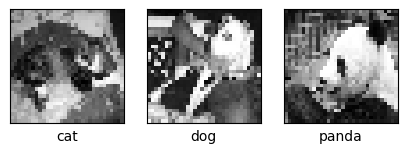

In [7]:
plt.figure(figsize=(5,10))
plt.subplot(1,3,1)
plt.imshow(np.reshape(train_data[1][0], (IMG_SIZE, IMG_SIZE)), cmap="gray")
plt.xlabel(target_keys[train_data[1][1]])
plt.xticks([])
plt.yticks([])

plt.subplot(1,3,2)
plt.imshow(np.reshape(train_data[1001][0], (IMG_SIZE, IMG_SIZE)), cmap="gray")
plt.xlabel(target_keys[train_data[1001][1]])
plt.xticks([])
plt.yticks([])

plt.subplot(1,3,3)
plt.imshow(np.reshape(train_data[2001][0], (IMG_SIZE, IMG_SIZE)), cmap="gray")
plt.xlabel(target_keys[train_data[2001][1]])
plt.xticks([])
plt.yticks([])
plt.show()

## KNN class

In [8]:
def l1_distance(x, y):
    return np.sum(np.abs(x - y))

In [9]:
def l2_distance(x, y):
    return np.sqrt(np.sum(np.square(x - y)))

In [10]:
class KNN:
    def __init__(self, k=3, mostcommon=1):
        self.k = k
        self.mc = mostcommon

    def fit(self, X, y):
        self.X = X
        self.y = y

    def predict(self, X, fn):
        predictions = [self._predict(x) for x in tqdm(X, desc=f'K: {self.k} | fold: {fn}/5 | ')]
        return predictions

    def _predict(self, x):
        D = [[l1_distance(x, xt), l2_distance(x, xt)] for xt in self.X]
        d1, d2 = np.array([d[0] for d in D]), np.array([d[1] for d in D])
        
        k_indices_1 = np.argsort(d1)[:self.k]
        k_indices_2 = np.argsort(d2)[:self.k]
        
        k_nearest_labels_1 = self.y[k_indices_1]
        k_nearest_labels_2 = self.y[k_indices_2]

        dl1 = Counter(k_nearest_labels_1).most_common(self.mc)
        dl2 = Counter(k_nearest_labels_2).most_common(self.mc)

        return [dl1, dl2]
        
    def score(self, X, y, fn):
        y_pred = self.predict(X, fn)
        
        l1_pred, l2_pred = [p[0] for p in y_pred], [p[1] for p in y_pred]
        l1_most_common_pred, l2_most_common_pred = np.array([i[0][0] for i in l1_pred]), np.array([i[0][0] for i in l2_pred])

        l1_avg_acc = np.sum(l1_most_common_pred == y) / len(y)
        l2_avg_acc = np.sum(l2_most_common_pred == y) / len(y)
        
        return [l1_avg_acc, l2_avg_acc]

    def plot_top_n_prediction_of_image(self, k, n, image, cls):
        self.k = k
        self.mc = n
        top_5_pred_l1, top_5_pred_l2 = self._predict(image)
        
        v_pred_1 = [g[0] for g in top_5_pred_l1]
        v_pop_1 =  [g[1] for g in top_5_pred_l1]
        v_pred_2 = [g[0] for g in top_5_pred_l2]
        v_pop_2 =  [g[1] for g in top_5_pred_l2]

        v_pred = v_pred_1 + v_pred_2
        # v_pred.append()
        # v_pred.append()
        v_pred = list(set(v_pred))
        
        plt.figure(figsize=(6,3))
        
        plt.subplot(1,2,1)
        plt.title(f'Top 5 predictions \nK = {self.k}')
        
        plt.barh(v_pred_1, width=v_pop_1, color='blue', label='L1')
        plt.barh(v_pred_2, width=v_pop_2, color='red', alpha=0.8, label='L2')

        plt.legend(loc='best')
        plt.xticks(range(n+2))
        plt.yticks(v_pred)
        plt.ylabel('Predictions')
        plt.xlabel('Popularity')
        
        
        l1_ans = 'fail'
        l2_ans = 'fail'

        if v_pred_1[0] == target[cls]:
            l1_ans = 'pass'
        if v_pred_2[0] == target[cls]:
            l2_ans = 'pass'
            
        plt.subplot(1,2,2)
        plt.title(f'L1: {l1_ans} and L2: {l2_ans}')
        
        plt.imshow(np.reshape(image, (32, 32)), cmap="gray")
        
        plt.xlabel(f'{cls} / {target[cls]}')
        plt.xticks([])
        plt.yticks([])
        
        plt.show()

### Seperate X_train and y_train from train data

In [11]:
X_train, y_train = np.array([sub[0] for sub in train_data]), np.array([sub[1] for sub in train_data])
print(type(X_train), type(y_train))
len(X_train), len(y_train)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


(3000, 3000)

## Generate cross validation pair

In [12]:
def gen_cv_pairs(n_folds, y):
    pairs = []

    indices = list(range(len(y)))
    
    class_indcs = [np.where(y_train == c)[0] for c in range(len(np.unique(y_train)))]
    
    class_indcs_split = [np.array_split(c, n_folds) for c in class_indcs] # splitting each 1000 images in `n_folds`

    folds = np.array([np.concatenate(args) for args in zip(*class_indcs_split)])
    
    for idx in range(n_folds):
        test_fold = folds[idx]
        
        train_folds = np.concatenate(np.delete(folds, idx, axis=0))

        pairs.append((train_folds, test_fold))

    return pairs

### 5 fold train and test pair

In [13]:
folds = gen_cv_pairs(5, y_train)

## Train

In [14]:
fold_accuracy_per_k = []
sn = ""

for kt in K:
    fold_accuracy = []
    fn = 0
    sn += f'k: {kt}\n'
    for (train_fold, test_fold) in folds:
        fn += 1
        
        clf = KNN(k=kt, mostcommon=1)
        clf.fit(X_train[train_fold], y_train[train_fold])
        score = clf.score(X_train[test_fold], y_train[test_fold], fn)
        
        sn += f'    f: {fn} [ avg accuracy (l1: {score[0]} -- l2: {score[1]}) ]\n'
        
        fold_accuracy.append(score)
    fold_accuracy_per_k.append(fold_accuracy)

K: 1 | fold: 1/5 | : 100%|██████████| 600/600 [00:27<00:00, 22.16it/s]
K: 1 | fold: 2/5 | : 100%|██████████| 600/600 [00:28<00:00, 21.16it/s]
K: 1 | fold: 3/5 | : 100%|██████████| 600/600 [00:25<00:00, 23.50it/s]
K: 1 | fold: 4/5 | : 100%|██████████| 600/600 [00:24<00:00, 24.58it/s]
K: 1 | fold: 5/5 | : 100%|██████████| 600/600 [00:23<00:00, 25.29it/s]
K: 3 | fold: 1/5 | : 100%|██████████| 600/600 [00:27<00:00, 21.98it/s]
K: 3 | fold: 2/5 | : 100%|██████████| 600/600 [00:25<00:00, 23.48it/s]
K: 3 | fold: 3/5 | : 100%|██████████| 600/600 [00:23<00:00, 25.17it/s]
K: 3 | fold: 4/5 | : 100%|██████████| 600/600 [00:24<00:00, 24.52it/s]
K: 3 | fold: 5/5 | : 100%|██████████| 600/600 [00:25<00:00, 23.11it/s]
K: 5 | fold: 1/5 | : 100%|██████████| 600/600 [00:25<00:00, 23.39it/s]
K: 5 | fold: 2/5 | : 100%|██████████| 600/600 [00:24<00:00, 24.07it/s]
K: 5 | fold: 3/5 | : 100%|██████████| 600/600 [00:25<00:00, 23.36it/s]
K: 5 | fold: 4/5 | : 100%|██████████| 600/600 [00:24<00:00, 24.54it/s]
K: 5 |

In [15]:
print(sn)

k: 1
    f: 1 [ avg accuracy (l1: 0.36 -- l2: 0.4083333333333333) ]
    f: 2 [ avg accuracy (l1: 0.3883333333333333 -- l2: 0.4216666666666667) ]
    f: 3 [ avg accuracy (l1: 0.4066666666666667 -- l2: 0.4066666666666667) ]
    f: 4 [ avg accuracy (l1: 0.355 -- l2: 0.4216666666666667) ]
    f: 5 [ avg accuracy (l1: 0.37666666666666665 -- l2: 0.42) ]
k: 3
    f: 1 [ avg accuracy (l1: 0.3566666666666667 -- l2: 0.425) ]
    f: 2 [ avg accuracy (l1: 0.3983333333333333 -- l2: 0.43) ]
    f: 3 [ avg accuracy (l1: 0.42333333333333334 -- l2: 0.41833333333333333) ]
    f: 4 [ avg accuracy (l1: 0.375 -- l2: 0.42333333333333334) ]
    f: 5 [ avg accuracy (l1: 0.43166666666666664 -- l2: 0.43333333333333335) ]
k: 5
    f: 1 [ avg accuracy (l1: 0.38166666666666665 -- l2: 0.4483333333333333) ]
    f: 2 [ avg accuracy (l1: 0.395 -- l2: 0.4533333333333333) ]
    f: 3 [ avg accuracy (l1: 0.4033333333333333 -- l2: 0.455) ]
    f: 4 [ avg accuracy (l1: 0.3883333333333333 -- l2: 0.4666666666666667) ]
    f: 

### Extracting L1 and L2 accuracy from accuracy blob

In [16]:
fold_l1_accuracy_per_k = []
fold_l2_accuracy_per_k = []
for fk in fold_accuracy_per_k:
    fl1, fl2 = [f[0] for f in fk], [f[1] for f in fk]
    fold_l1_accuracy_per_k.append(fl1)
    fold_l2_accuracy_per_k.append(fl2)
    
print(fold_l1_accuracy_per_k, '\n')
print(fold_l2_accuracy_per_k)

[[0.36, 0.3883333333333333, 0.4066666666666667, 0.355, 0.37666666666666665], [0.3566666666666667, 0.3983333333333333, 0.42333333333333334, 0.375, 0.43166666666666664], [0.38166666666666665, 0.395, 0.4033333333333333, 0.3883333333333333, 0.4266666666666667], [0.38666666666666666, 0.3983333333333333, 0.41333333333333333, 0.415, 0.44166666666666665], [0.4066666666666667, 0.37166666666666665, 0.405, 0.4083333333333333, 0.44]] 

[[0.4083333333333333, 0.4216666666666667, 0.4066666666666667, 0.4216666666666667, 0.42], [0.425, 0.43, 0.41833333333333333, 0.42333333333333334, 0.43333333333333335], [0.4483333333333333, 0.4533333333333333, 0.455, 0.4666666666666667, 0.445], [0.45166666666666666, 0.47, 0.4633333333333333, 0.48833333333333334, 0.465], [0.48, 0.47833333333333333, 0.4766666666666667, 0.525, 0.4866666666666667]]


## Stats

In [17]:
mean_accuracies_l1 = np.array([np.mean(acc) for acc in fold_l1_accuracy_per_k])
std_accuracies_l1 = np.array([np.std(acc)  for acc in fold_l1_accuracy_per_k])
mean_accuracies_l2 = np.array([np.mean(acc) for acc in fold_l2_accuracy_per_k])
std_accuracies_l2 = np.array([np.std(acc)  for acc in fold_l2_accuracy_per_k])

print(f'mean accuracies l1: {mean_accuracies_l1} \nmean accuracies l2: {mean_accuracies_l2}')
print(f'std deviation l1: {std_accuracies_l1} \nstd deviation l2: {std_accuracies_l2}')

mean accuracies l1: [0.37733333 0.397      0.399      0.411      0.40633333] 
mean accuracies l2: [0.41566667 0.426      0.45366667 0.46766667 0.48933333]
std deviation l1: [0.01887385 0.02831176 0.01558489 0.01851726 0.02163844] 
std deviation l2: [0.00671648 0.00522813 0.0074087  0.01195361 0.01815367]


## Plot

### L1 and L2 score plot

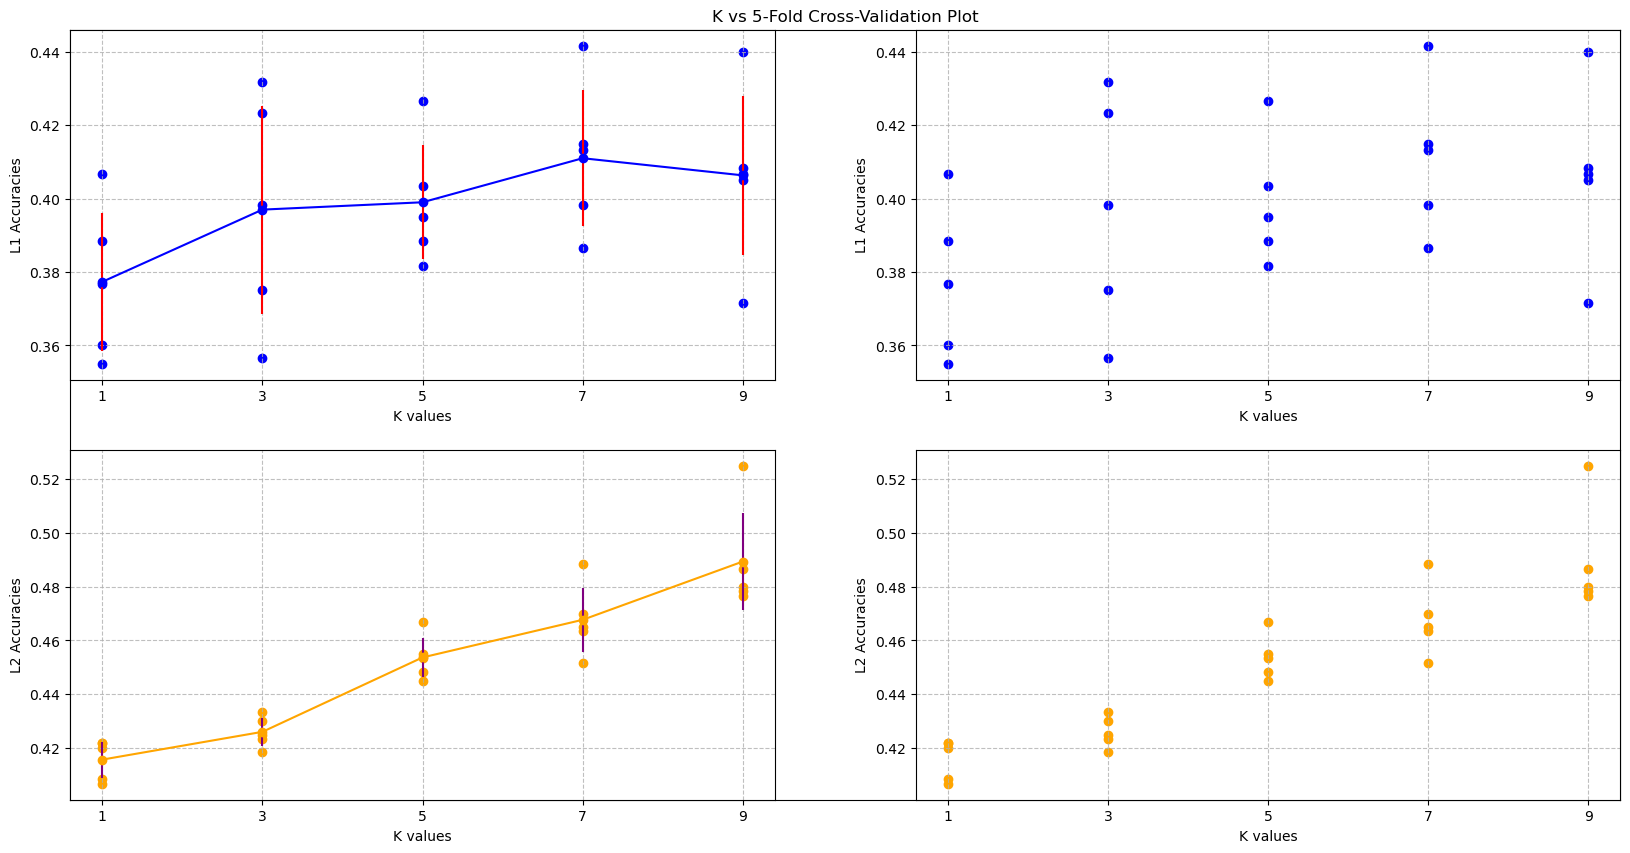

In [18]:
plt.figure(figsize=(20, 10))
plt.title('K vs 5-Fold Cross-Validation Plot')
plt.xticks([])
plt.yticks([])

for i in range(len(K)):
    accuracies_l1 = fold_l1_accuracy_per_k[i]
    plt.subplot(2,2,1)
    plt.scatter([K[i]]*len(accuracies_l1), accuracies_l1, c='blue')
    
    plt.subplot(2,2,2)
    plt.scatter([K[i]]*len(accuracies_l1), accuracies_l1, c='blue')

    accuracies_l2 = fold_l2_accuracy_per_k[i]
    plt.subplot(2,2,3)
    plt.scatter([K[i]]*len(accuracies_l2), accuracies_l2, c='orange')
    
    plt.subplot(2,2,4)
    plt.scatter([K[i]]*len(accuracies_l2), accuracies_l2, c='orange')

plt.subplot(2,2,1)
plt.errorbar(K, mean_accuracies_l1, yerr=std_accuracies_l1, marker='o', color='b', linestyle='-', ecolor='r')
plt.grid(True, linestyle='--', alpha=0.8)
plt.xticks(K)
plt.xlabel('K values')
plt.ylabel('L1 Accuracies')

plt.subplot(2,2,3)
plt.errorbar(K, mean_accuracies_l2, yerr=std_accuracies_l2, marker='o', color='orange', linestyle='-', ecolor='purple')
plt.grid(True, linestyle='--', alpha=0.8)
plt.xticks(K)
plt.xlabel('K values')
plt.ylabel('L2 Accuracies')

plt.subplot(2,2,2)
plt.grid(True, linestyle='--', alpha=0.8)
plt.xticks(K)
plt.xlabel('K values')
plt.ylabel('L1 Accuracies')

plt.subplot(2,2,4)
plt.grid(True, linestyle='--', alpha=0.8)
plt.xticks(K)
plt.xlabel('K values')
plt.ylabel('L2 Accuracies')


plt.show()

### Combined L1 and L2 score plot

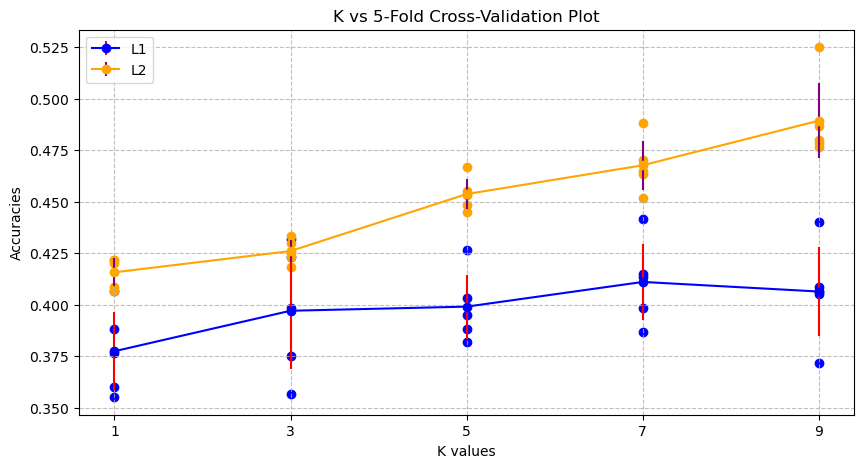

In [27]:
plt.figure(figsize=(10, 5))
plt.title('K vs 5-Fold Cross-Validation Plot')
plt.xticks(K)

for i in range(len(K)):
    accuracies_l1 = fold_l1_accuracy_per_k[i]
    plt.scatter([K[i]]*len(accuracies_l1), accuracies_l1, c='blue')
    
    accuracies_l2 = fold_l2_accuracy_per_k[i]
    plt.scatter([K[i]]*len(accuracies_l2), accuracies_l2, c='orange')

plt.errorbar(K, mean_accuracies_l1, yerr=std_accuracies_l1, marker='o', color='b', linestyle='-', ecolor='r', label='L1')
plt.errorbar(K, mean_accuracies_l2, yerr=std_accuracies_l2, marker='o', color='orange', linestyle='-', ecolor='purple', label='L2')

plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.8)
plt.xlabel('K values')
plt.ylabel('Accuracies')

plt.show()

## Top 5 prediction

In [20]:
def plot_top5_from_image_path(k, n, cls, img_no):
    image_path = f'datasets/kaggle_cats_dogs_pandas/test/{cls}/{cls}s_{img_no}.jpg'
    image_data = get_image_data_from_path(image_path, 32, resize=True)

    clf = KNN(k, n)
    clf.fit(X_train, y_train)
    clf.plot_top_n_prediction_of_image(k, n, image_data, cls)


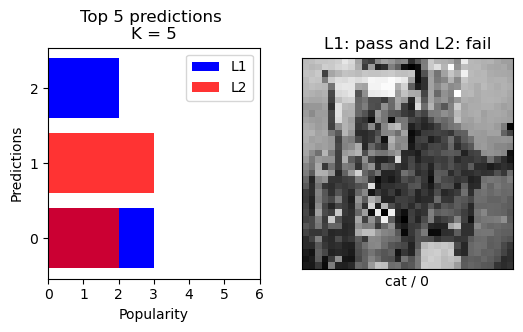

In [21]:
plot_top5_from_image_path(5, 5, 'cat', '00001')

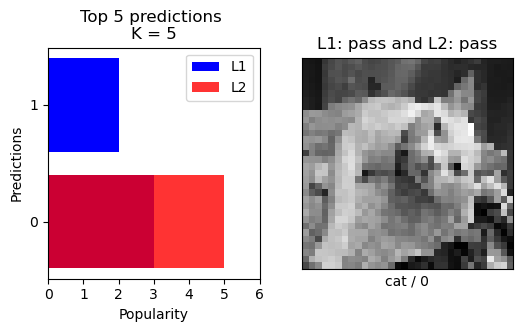

In [22]:
plot_top5_from_image_path(5, 5, 'cat', '00020')

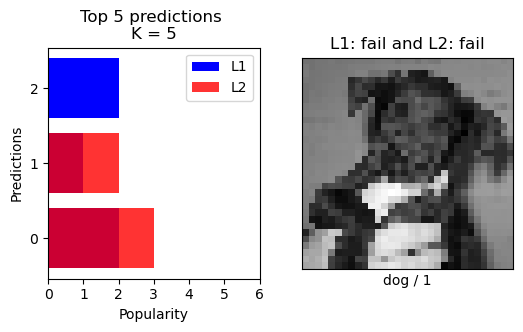

In [23]:
plot_top5_from_image_path(5, 5, 'dog', '01000')

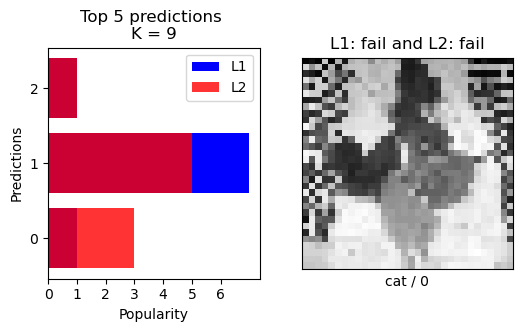

In [24]:
plot_top5_from_image_path(9, 5, 'cat', '00101')

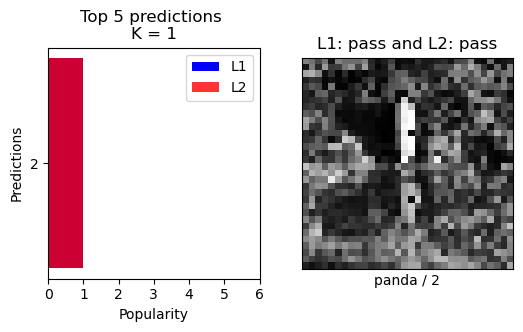

In [25]:
plot_top5_from_image_path(1, 5, 'panda', '00200')

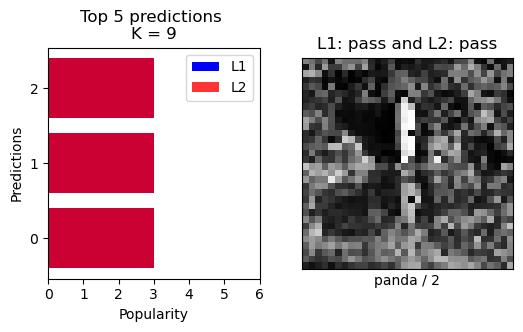

In [26]:
plot_top5_from_image_path(9, 5, 'panda', '00200')

## Discussion

The bar graphs above presents the accuracy outcomes for Manhattan (L1) and Euclidean (L2) distance metrics using a 5-fold cross-validation approach with varying values of k.

The L1 distance is computed by summing the absolute difference between coordinates or data points vs the L2 distance is computed by squaring the difference.

This project compared both disances using the *cat_dog_panda* dataset comprised of a 1000 RGBA images for each category, which were then converted to grayscale 32x32 images for efficiency.

L1 accuracy: 4/6 correct predictions from above bar charts. L2 accuracy: 3/6 correct predictions from above bar charts. It finds more outlier datapoints from the bunch.

However the accuracy chart shows the L1 distance performing poorly in contrast to the L2 distance thoughout the different values of *K*.